In [3]:
import json
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter

In [1]:
import json

# Load the QSF file
file_path = '/mnt/data/cillm-eng-final.qsf'

with open(file_path, 'r') as file:
    qsf_data = json.load(file)

# Display the structure of the QSF file to understand its contents
qsf_data.keys()

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/cillm-eng-final.qsf'

In [5]:
with open("../data/activity.json", "r") as file:
    data = [json.loads(line) for line in file]

In [6]:
data


[{'_id': {'$oid': '66a7ab000e1a9cb0f46c430e'},
  'document_id': '66a7a8478c6b75c95c049683',
  'task_id': 'sandbox_task_1_eng_A',
  'prolific_id': '123',
  'activity_log': {'buttonClicks': [{'action': 'CREATE VARIATION',
     'timestamp': '2024-07-29T14:33:49.005Z'},
    {'action': 'recipe_Gain_Anecdotal',
     'timestamp': '2024-07-29T14:34:04.339Z'},
    {'action': 'CREATE CONTINUATION', 'timestamp': '2024-07-29T14:45:03.199Z'},
    {'action': 'DELETE CHUNK', 'timestamp': '2024-07-29T14:45:17.826Z'},
    {'action': 'DELETE VERSION', 'timestamp': '2024-07-29T14:45:17.850Z'}],
   'generatedContent': [{'feature': 'Gain Framing with Anecdotal Information',
     'prompt': 'Rewrite the sentence(s) to include a positive anecdotal story that highlights the benefits',
     'response': 'Here is a positive anecdotal story highlighting the benefits: A person used these steps and experienced significant improvement in their situation, making them feel more confident and capable.',
     'timestamp'

In [7]:
# Function to convert timestamp strings to datetime objects
def parse_timestamp(timestamp_str):
    return datetime.strptime(timestamp_str, "%Y-%m-%dT%H:%M:%S.%fZ")

# Function to analyze modifications after generated content
def analyze_modifications(data):
    analysis_results = []

    for record in data:
        doc_id = record.get("document_id")
        generated_content = record.get("activity_log", {}).get("generatedContent", [])
        keylogs = record.get("activity_log", {}).get("keyLogs", [])

        for content in generated_content:
            response = content.get("response", "")
            gen_timestamp = parse_timestamp(content.get("timestamp"))
            post_edit_keys = []
            post_edit_key_events = []

            # Check keylogs for actions after the generated content timestamp
            for keylog in keylogs:
                keylog_timestamp = parse_timestamp(keylog.get("timestamp"))
                if keylog_timestamp > gen_timestamp:
                    post_edit_keys.append(keylog.get("key"))
                    post_edit_key_events.append(keylog)

            # Determine modification status
            if post_edit_keys:
                modification_status = "Modified"
            else:
                modification_status = "Not Modified"

            analysis_results.append({
                "document_id": doc_id,
                "generated_content": response,
                "generated_timestamp": gen_timestamp,
                "post_edit_keys": post_edit_keys,
                "post_edit_key_events": post_edit_key_events,
                "modification_status": modification_status
            })

    return analysis_results

# Perform the analysis
analysis_results = analyze_modifications(data)

# Display a few sample results for review
analysis_results[:2]  # Show the first two entries for brevity

[{'document_id': '66a7a8478c6b75c95c049683',
  'generated_content': 'Here is a positive anecdotal story highlighting the benefits: A person used these steps and experienced significant improvement in their situation, making them feel more confident and capable.',
  'generated_timestamp': datetime.datetime(2024, 7, 29, 14, 34, 24, 800000),
  'post_edit_keys': [],
  'post_edit_key_events': [],
  'modification_status': 'Not Modified'},
 {'document_id': '66a7a8478c6b75c95c049683',
  'generated_content': 'Below this type @ai followed by some text to ask AI to write a piece of Here is the continuation:text: Below this type @ai followed by some text to ask AI to write a piece of poetry.',
  'generated_timestamp': datetime.datetime(2024, 7, 29, 14, 45, 6, 475000),
  'post_edit_keys': [],
  'post_edit_key_events': [],
  'modification_status': 'Not Modified'}]

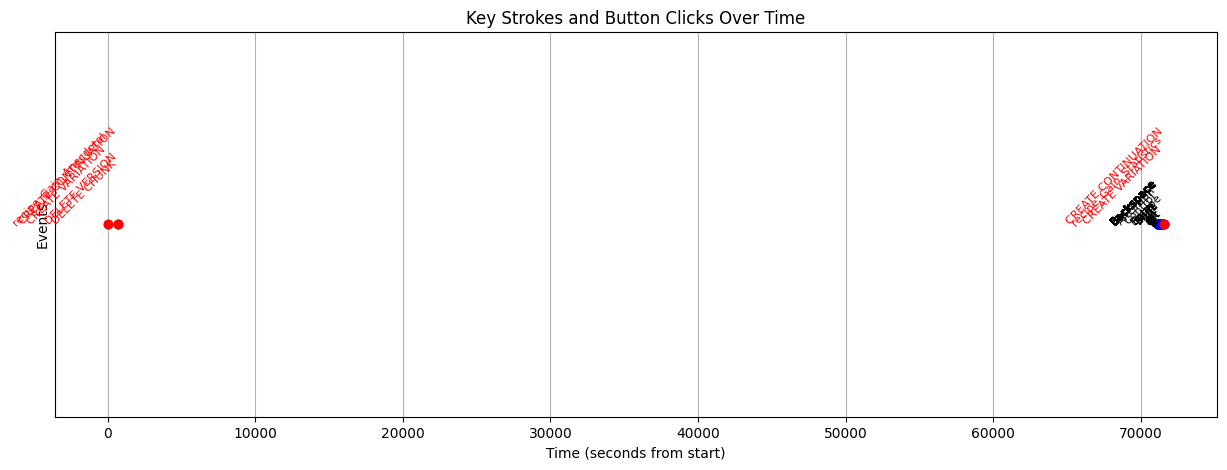

In [9]:
# Extracting all keylogs and button clicks with their timestamps for visualization
key_events = []
button_events = []

# Collecting keylogs and button clicks with timestamps
for record in data:
    doc_id = record.get("document_id")
    keylogs = record.get("activity_log", {}).get("keyLogs", [])
    button_clicks = record.get("activity_log", {}).get("buttonClicks", [])

    for keylog in keylogs:
        key_events.append({
            "type": "key",
            "action": keylog.get("key"),
            "timestamp": parse_timestamp(keylog.get("timestamp"))
        })
    
    for click in button_clicks:
        button_events.append({
            "type": "button",
            "action": click.get("action"),
            "timestamp": parse_timestamp(click.get("timestamp"))
        })

# Combine key events and button clicks
all_events = key_events + button_events

# Sort events by timestamp
all_events.sort(key=lambda x: x["timestamp"])

# Normalize timestamps to start from t=0
start_time = all_events[0]["timestamp"]
for event in all_events:
    event["normalized_time"] = (event["timestamp"] - start_time).total_seconds()

# Visualizing the events
plt.figure(figsize=(15, 5))

# Plot key events
for event in all_events:
    if event["type"] == "key":
        plt.plot(event["normalized_time"], 1, 'bo')  # blue dot for keys
    else:
        plt.plot(event["normalized_time"], 1, 'ro')  # red dot for buttons

plt.title('Key Strokes and Button Clicks Over Time')
plt.xlabel('Time (seconds from start)')
plt.ylabel('Events')
plt.yticks([])  # Hide y-axis as it only represents events
plt.grid(True)

# Adding legends and labels
for event in all_events:
    if event["type"] == "key":
        plt.text(event["normalized_time"], 1, event["action"], fontsize=8, rotation=45, ha='right')
    else:
        plt.text(event["normalized_time"], 1, event["action"], fontsize=8, rotation=45, ha='right', color='red')

plt.show()


In [25]:
document_id

'66a7a8478c6b75c95c049683'

In [34]:
# Grouping events by prolific_id and task_id for visualization
from collections import defaultdict

# Initialize a nested dictionary for storing events grouped by prolific_id and task_id
events_grouped = defaultdict(lambda: defaultdict(list))

# Group the events by prolific_id and task_id
for record in data:
    prolific_id = record.get("prolific_id")
    task_id = record.get("task_id")
    keylogs = record.get("activity_log", {}).get("keyLogs", [])
    button_clicks = record.get("activity_log", {}).get("buttonClicks", [])

    for keylog in keylogs:
        events_grouped[prolific_id][task_id].append({
            "type": "key",
            "action": keylog.get("key"),
            "timestamp": parse_timestamp(keylog.get("timestamp"))
        })
    
    for click in button_clicks:
        events_grouped[prolific_id][task_id].append({
            "type": "button",
            "action": click.get("action"),
            "timestamp": parse_timestamp(click.get("timestamp"))
        })

# Normalize timestamps and prepare for plotting
for prolific_id, tasks in events_grouped.items():
    for task_id, events in tasks.items():
        # Sort events by timestamp
        events.sort(key=lambda x: x["timestamp"])
        
        # Normalize timestamps to start from t=0
        if events:
            start_time = events[0]["timestamp"]
            for event in events:
                event["normalized_time"] = (event["timestamp"] - start_time).total_seconds()

# Preparing data for visualization for each prolific_id and task_id combination
# Example for one user and task
prolific_id = list(events_grouped.keys())[0]
task_id = list(events_grouped[prolific_id].keys())[0]
events_to_plot = events_grouped[prolific_id][task_id]

events_to_plot


[{'type': 'button',
  'action': 'CREATE VARIATION',
  'timestamp': datetime.datetime(2024, 7, 29, 14, 33, 49, 5000),
  'normalized_time': 0.0},
 {'type': 'button',
  'action': 'recipe_Gain_Anecdotal',
  'timestamp': datetime.datetime(2024, 7, 29, 14, 34, 4, 339000),
  'normalized_time': 15.334},
 {'type': 'button',
  'action': 'CREATE CONTINUATION',
  'timestamp': datetime.datetime(2024, 7, 29, 14, 45, 3, 199000),
  'normalized_time': 674.194},
 {'type': 'button',
  'action': 'DELETE CHUNK',
  'timestamp': datetime.datetime(2024, 7, 29, 14, 45, 17, 826000),
  'normalized_time': 688.821},
 {'type': 'button',
  'action': 'DELETE VERSION',
  'timestamp': datetime.datetime(2024, 7, 29, 14, 45, 17, 850000),
  'normalized_time': 688.845},
 {'type': 'key',
  'action': 'Enter',
  'timestamp': datetime.datetime(2024, 7, 30, 10, 20, 1, 691000),
  'normalized_time': 71172.686},
 {'type': 'key',
  'action': 'Control',
  'timestamp': datetime.datetime(2024, 7, 30, 10, 20, 2, 424000),
  'normalized_

In [35]:
filtered_events = [event for event in events if event["normalized_time"] > 65000]


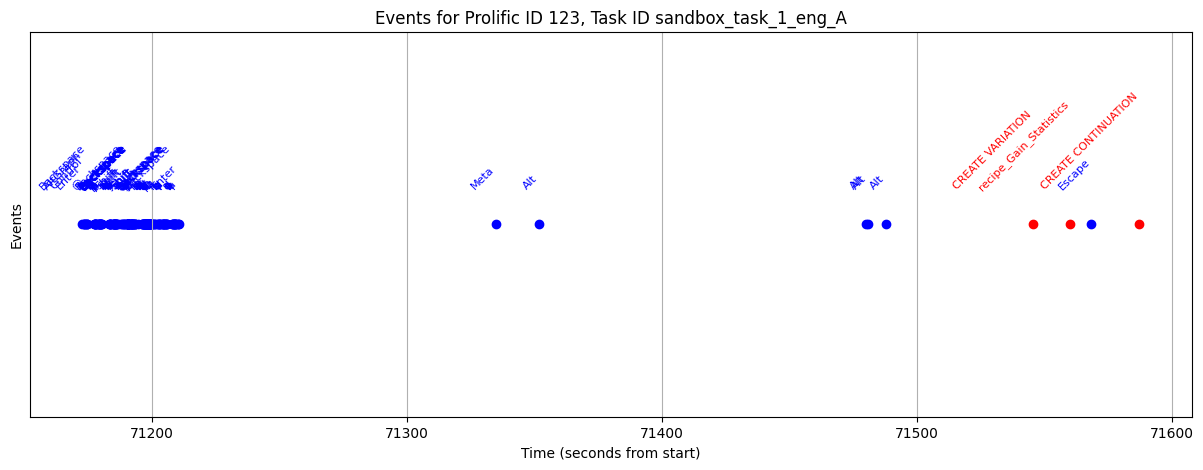

In [32]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Group events
# events_grouped = defaultdict(lambda: defaultdict(list))

# Collect and normalize events as shown in previous steps
# ...

# Example visualization for a specific prolific_id and task_id
# prolific_id = '123'
# task_id = 'sandbox_task_1_eng_A'
# events_to_plot = events_grouped[prolific_id][task_id]

plt.figure(figsize=(15, 5))
for event in filtered_events:
    color = 'blue' if event["type"] == "key" else 'red'
    plt.scatter(event["normalized_time"], 1, c=color)
    plt.text(event["normalized_time"], 1.01, event["action"], fontsize=8, rotation=45, ha='right', color=color)

plt.title(f'Events for Prolific ID {prolific_id}, Task ID {task_id}')
plt.xlabel('Time (seconds from start)')
plt.ylabel('Events')
plt.yticks([])
plt.grid(True)
plt.show()


In [36]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [37]:
# Prepare data for plotting
key_events = [event for event in filtered_events if event["type"] == "key"]
button_events = [event for event in filtered_events if event["type"] == "button"]

# Create plotly figure
fig = make_subplots()

# Add key events
fig.add_trace(go.Scatter(
    x=[event["normalized_time"] for event in key_events],
    y=[1] * len(key_events),
    mode='markers+text',
    name='Key Strokes',
    text=[event["action"] for event in key_events],
    textposition='top center',
    marker=dict(color='blue', size=10)
))

# Add button events
fig.add_trace(go.Scatter(
    x=[event["normalized_time"] for event in button_events],
    y=[1] * len(button_events),
    mode='markers+text',
    name='Button Clicks',
    text=[event["action"] for event in button_events],
    textposition='top center',
    marker=dict(color='red', size=10)
))

# Update layout for better viewing
fig.update_layout(
    title=f'Interactive Events for Document ID {doc_id} After {x_seconds} Seconds',
    xaxis_title='Time (seconds from start)',
    yaxis_title='Events',
    yaxis=dict(showticklabels=False),  # Hide y-axis labels
    showlegend=True
)

# Display the figure
fig.show()


In [38]:
x_seconds = 65000
generated_content = []
for record in data:
    if record.get("document_id") == doc_id:
        content_list = record.get("activity_log", {}).get("generatedContent", [])
        for content in content_list:
            prompt_response = content.get("prompt", "") + " " + content.get("response", "")
            timestamp = parse_timestamp(content.get("timestamp"))
            normalized_time = (timestamp - start_time).total_seconds()
            if normalized_time > x_seconds:
                generated_content.append({
                    "text": prompt_response,
                    "timestamp": timestamp,
                    "normalized_time": normalized_time
                })

In [39]:
fig = make_subplots()

# Plot key events
key_events = [event for event in filtered_events if event["type"] == "key"]
fig.add_trace(go.Scatter(
    x=[event["normalized_time"] for event in key_events],
    y=[1] * len(key_events),
    mode='markers+text',
    name='Key Strokes',
    text=[event["action"] for event in key_events],
    textposition='top center',
    marker=dict(color='blue', size=10)
))

# Plot button click events
button_events = [event for event in filtered_events if event["type"] == "button"]
fig.add_trace(go.Scatter(
    x=[event["normalized_time"] for event in button_events],
    y=[1] * len(button_events),
    mode='markers+text',
    name='Button Clicks',
    text=[event["action"] for event in button_events],
    textposition='top center',
    marker=dict(color='red', size=10)
))

# Plot generated content events
fig.add_trace(go.Scatter(
    x=[content["normalized_time"] for content in generated_content],
    y=[1] * len(generated_content),
    mode='markers+text',
    name='Generated Content',
    text=[content["text"] for content in generated_content],
    textposition='top center',
    marker=dict(color='green', size=10)
))

# Update layout for better viewing
fig.update_layout(
    title=f'Interactive Events for Document ID {doc_id} After {x_seconds} Seconds',
    xaxis_title='Time (seconds from start)',
    yaxis=dict(showticklabels=False),  # Hide y-axis labels
    showlegend=True
)

# Display the figure
fig.show()

In [41]:

event = filtered_events
fig = make_subplots()

# Plot key events
fig.add_trace(go.Scatter(
    x=[event["normalized_time"] for event in events if event["type"] == "key"],
    y=[1] * len(events),
    mode='markers+text',
    name=f'Key Strokes - {doc_id}',
    text=[event["action"] for event in events if event["type"] == "key"],
    textposition='top center',
    marker=dict(color='blue', size=10)
))

# Plot button clicks
fig.add_trace(go.Scatter(
    x=[event["normalized_time"] for event in events if event["type"] == "button"],
    y=[1] * len(events),
    mode='markers+text',
    name=f'Button Clicks - {doc_id}',
    text=[event["action"] for event in events if event["type"] == "button"],
    textposition='top center',
    marker=dict(color='red', size=10)
))

# Plot generated content
fig.add_trace(go.Scatter(
    x=[content["normalized_time"] for content in generated_content],
    y=[1] * len(generated_content),
    mode='markers+text',
    name=f'Generated Content - {doc_id}',
    text=[content["text"] for content in generated_content],
    textposition='top center',
    marker=dict(color='green', size=10)
))

fig.update_layout(
    title='Interactive Events for All Document IDs After {x_seconds} Seconds',
    xaxis_title='Time (seconds from start)',
    yaxis=dict(showticklabels=False),
    showlegend=True
)

fig.show()

In [42]:
import plotly.express as px
data_canada = px.data.gapminder().query("country == 'Canada'")
fig = px.bar(data_canada, x='year', y='pop')
fig.show()

In [43]:
data_canada

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
240,Canada,Americas,1952,68.750,14785584,11367.16112,CAN,124
241,Canada,Americas,1957,69.960,17010154,12489.95006,CAN,124
242,Canada,Americas,1962,71.300,18985849,13462.48555,CAN,124
243,Canada,Americas,1967,72.130,20819767,16076.58803,CAN,124
244,Canada,Americas,1972,72.880,22284500,18970.57086,CAN,124
245,Canada,Americas,1977,74.210,23796400,22090.88306,CAN,124
246,Canada,Americas,1982,75.760,25201900,22898.79214,CAN,124
247,Canada,Americas,1987,76.860,26549700,26626.51503,CAN,124
248,Canada,Americas,1992,77.950,28523502,26342.88426,CAN,124
249,Canada,Americas,1997,78.610,30305843,28954.92589,CAN,124


In [ ]:
pseudo_results = defaultdict()
pseudo_results['baseline'].append({
    ''
})

In [54]:
import plotly.graph_objects as go

# Sample data for each feature and category
features = [
    "% of LLM content used",
    "# of times @ai feature used",
    "Perceived utility of @ai feature used",
    "Explorative features - ownership",
    "Explorative features - benefits of co-writing"
]

baseline = [30, 40, 50, 60, 70]   # Sample data for baseline
l1_l2 = [20, 30, 40, 50, 60]      # Sample data for l1-l2
l2_l1 = [10, 20, 30, 40, 50]      # Sample data for l2-l1
no_llm = [10, 30, 20, 10, 25]
# Creating the bar plot
fig = go.Figure()

fig.add_trace(go.Bar(
    x=features,
    y=baseline,
    name='Baseline_language'
))
fig.add_trace(go.Bar(
    x=features,
    y=no_llm,
    name='Baseline_No_LLM'
))

fig.add_trace(go.Bar(
    x=features,
    y=l1_l2,
    name='L1-L2'
))

fig.add_trace(go.Bar(
    x=features,
    y=l2_l1,
    name='L2-L1'
))


# Updating layout
fig.update_layout(
    title='Comparison of Features Across Categories for english (L1)',
    xaxis_title='Features',
    yaxis_title='Values',
    barmode='group',
    legend_title='Categories'
)

fig.show()


In [55]:
features = [
    "% of LLM content used",
    "# of times @ai feature used",
    "Perceived utility of @ai feature used",
    "Explorative features - ownership",
    "Explorative features - benefits of co-writing"
]

baseline = [70, 40, 50, 60, 10]   # Sample data for baseline
l1_l2 = [20, 80, 30, 50, 60]      # Sample data for l1-l2
l2_l1 = [10, 50, 30, 20, 50]      # Sample data for l2-l1
no_llm = [35, 15, 20, 90, 75]
# Creating the bar plot
fig = go.Figure()

fig.add_trace(go.Bar(
    x=features,
    y=baseline,
    name='Baseline_Language'
))

fig.add_trace(go.Bar(
    x=features,
    y=no_llm,
    name='Baseline_No_LLM'
))

fig.add_trace(go.Bar(
    x=features,
    y=l1_l2,
    name='L1-L2'
))

fig.add_trace(go.Bar(
    x=features,
    y=l2_l1,
    name='L2-L1'
))

# Updating layout
fig.update_layout(
    title='Comparison of Features Across Categories for spanish (L1)',
    xaxis_title='Features',
    yaxis_title='Values',
    barmode='group',
    legend_title='Categories'
)

fig.show()